In [222]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Parameters
alpha, beta = 10, 10  
c1, c2 = 0.5, 0.5 

z1, z2 = 0.5 + 0.5j, 0.5 + 0.5j

cap = cv2.VideoCapture('video.3gp')
while cap.isOpened():
    f,a = cap.read()
    cap.release()

print(f'Image shape {a.shape}')

#define water markt
water = np.zeros(shape=(100,100))
for i in range(100):
    for j in range(100):
        water[::2,j] = 255
    water[i,::2] = 255

print(water.shape)

z1 = 0.2 + 0.6j
z2 = 0.1 + 0.2j
A = 5
B = 5

def embedEX(I, water, A, B, z1, z2, type:bool):

    #split channel
    r, g, b = a[:,:,0], a[:,:,1], a[:,:,2]
    
    #Water mark size
    rw, cw = water.shape
    EW = np.zeroes(shape=(rw,cw))
    
    #LLBand
    rLL,rLH,rHL,rHH = pywt.dwt2(r, 'db1',)
    gLL,gLH,gHL,gHH = pywt.dwt2(g, 'db1',)
    bLL,bLH,bHL,bHH = pywt.dwt2(b, 'db1',)
    
    #get size of LLband
    rc, cc = rLL.shape
    
    #MASK
    mask = np.zeros(rc,cc,3)
    
    #CFOLD
    def CFOLD(Z):
        return Z.real%1 + (Z.imag%1)*1j
    
    #Main loop
    for i in range(1,rw):
        for j in range(1,cw):
            
            while True:
                #Z1, Z2 and CFOLD computation
                z1 = CFOLD(A*((z1/z2)**2)) # + c1 ignored for now
                z2 = CFOLD(B*((z2/z1)**2)) # + c2 ignored 
    
                #X and Y
                x = np.floor(z1.real*(10**14))%rc/4
                y = np.floor(z1.imag*(10**14))%cc/4
    
                #channel
                channel = np.floor(z2.real*(10**14))%3
    
                #bit encryption
                bita = np.floor(z2.imag*(10**14))%2
                if mask[x+1,y+1,channel] == 0:
                    break

        #Block
        if channel == 0:
            block = rLL[x*4+1: x*4+4, y*4+1: y*4+4]
        elif channel == 1:
            block = bLL[x*4+1: x*4+4, y*4+1: y*4+4]
        else:
            block = gLL[x*4+1: x*4+4, y*4+1: y*4+4]

        #SVD
        U, S, V = np.linalg.svd(block)

        #EMBED & EXTRACT
        #embed
        if type == 0:
            
            #Get mean of first two elements of first U vector
            meanV = (np.abs(U[1,1])+np.abs(U[2,1]))/2

            #WaterMarking
            if water[i,j] == 0:
                if np.abs(U[1,1]) > np.abs(U[2,1]) and np.abs(U[2,1]) - np.abs(U[1,1]) < T: # defin T later
                    U[1,1] = np.sign(U[1,1]) * (meanV + T/2)
                    U[2,1] = np.sign(U[2,1]) * (meanV - T/2)

            water[i,j] = water[i,j] ^ bita # ENCRYPTION PROCESS
            
            if water[i,j] == 1:
                if np.abs(U[1,1]) < np.abs(U[2,1]) and np.abs(U[2,1]) - np.abs(U[1,1]) > T: # defin T later
                    U[1,1] = np.sign(U[1,1]) * (meanV - T/2)
                    U[2,1] = np.sign(U[2,1]) * (meanV + T/2)

            #Reconstruction
            rank = S.size
            recon = U[:,:rank]@np.diag(S)@V[:rank,:]
            if channel == 0:
                rLL[x*4+1: x*4+4, y*4+1: y*4+4] = recon
            elif channel == 1:
                gLL[x*4+1: x*4+4, y*4+1: y*4+4] = recon
            else:
                bLL[x*4+1: x*4+4, y*4+1: y*4+4] = recon

        #EXTRACTION
        if type == 1:
            if np.abs(U[1,1]) > np.abs(U[2,1]):
                EW[i,j] = 0
            else:
                EW[i,j] = 1
            EW[i,j] = EW[i,j] ^ bita #DECRYPTION PROCESS
        mask[x+1,y+1,channel] = 1
    
    #Save final Z1, Z2 for initial conditions of next frame
    if type == 0:
        WIr = pywt.idwt2(recon, rLH,rHL,rHH)
        WIg = pywt.idwt2(recon, gLH,gHL,gHH)
        WIb = pywt.idwt2(recon, bLH,bHL,bHH)
        WI = np.array([WIr,WIg,WIb])
        return WI
    else:
        return EW

        

Image shape (720, 1280, 3)
(100, 100)


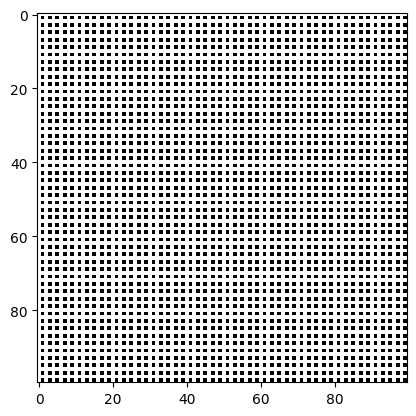

In [149]:
plt.imshow(water, cmap='gray')

In [174]:
import pywt



(dc, (er, rt, pp)) = pywt.dwt2(a, 'bior1.3',)# mode='symmetric')

0
1
2
3


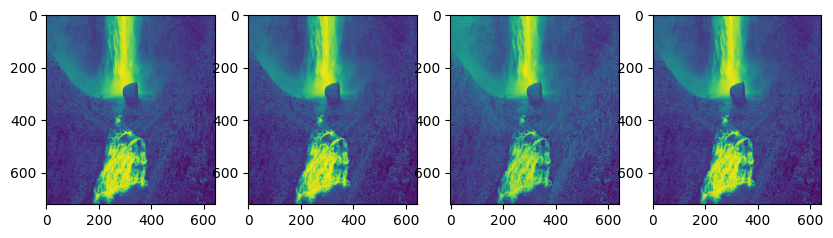

In [187]:
fif = plt.figure(figsize=(10,5))
for i in range(4):
    print(i)
    fif.add_subplot(1,4,i+1)
    plt.imshow(dc[:,:,i])
    

In [198]:
er = dc[:,:,0]
u,s,v = np.linalg.svd(er)

array([[-0.04148703, -0.0324289 , -0.01577024, ..., -0.05035124,
         0.06172108, -0.00781645],
       [-0.04159139, -0.03285876, -0.01678912, ...,  0.05938249,
        -0.07891556, -0.00740869],
       [-0.04159976, -0.03301425, -0.01714774, ..., -0.0140631 ,
         0.04516551, -0.00069242],
       ...,
       [-0.01497666,  0.02998464, -0.02315951, ...,  0.08717695,
        -0.0977982 ,  0.08496936],
       [-0.01515031,  0.02885972, -0.02355099, ..., -0.07484601,
         0.1162267 , -0.05204679],
       [-0.01494633,  0.02695464, -0.02171847, ...,  0.05454326,
        -0.0763909 ,  0.02147889]])

In [199]:
er.shape

(720, 642)

In [213]:
re = u[:,:rank]@np.diag(s)@v[:rank,:]

In [214]:
u[:,:642].shape, np.diag(s).shape, v[:642,:].shape

((720, 642), (642, 642), (642, 642))

In [219]:
np.allclose(er, re)

True

In [220]:
er
EW[1,2] = 2

NameError: name 'EW' is not defined